下载和缓存数据集

In [46]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [47]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [48]:
def download(name, cache_dir=os.path.join('..', 'data')):
    assert name in DATA_HUB, f'{name}不存在于{DATA_HUB}'
    url, shal_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        shal = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                shal.update(data)
            if shal.hexdigest() == shal_hash:
                return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [49]:
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [50]:
def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [51]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [52]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [53]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [54]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [55]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])  # 对数据进行位置索引，提取数据 [row, col]

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [56]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

数据预处理
缺失值：替换为平均值
标准化数据：特征缩放为均值为0，方差为单位方差
方便优化、不知道哪些特征是相关的，不将惩罚分配给一个特征系数比分配给其他任何特征的系数大

In [57]:
# 若无法获取测试数据，可根据训练数据计算均值和标准差，反之整体进行计算
# 获取所有数值的索引集合
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
"""
    apply(function) 在数据表上进行批量操作
    function:
        python的内置函数，如np.square()
        自定义的函数，def 定义函数或 lambda 自定义的函数
"""
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# 缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [58]:
# 对object类型的features进行 one-hot encode，同时dummy_na=True表示na也是为有效特征值进行编码
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [59]:
n_train = train_data.shape[0]
# pandas是numpy格式，转为tensor
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

训练

In [60]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [61]:
def log_rmse(net, features, labels):
    # 将输入input张量每个元素的范围限制到区间 [min, max]，返回结果到一个新张量
    # float('inf') 正无穷
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    # 返回一个标量，要求元素个数为1
    return rmse.item()

In [62]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Adam优化器对初始学习率不敏感
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

K折交叉验证

In [63]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # 索引切片
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train == None:
            X_train, y_train = X_part, y_part
        else:
            # 第二个参数是 dim
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [64]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # data是个集合需要使用 *data 解构赋值
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)

        # 获取每i折训练 num_epochs 次后最后一次的 train_ls and valid_ls
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.169951, 验证log rmse0.157265
折2，训练log rmse0.162286, 验证log rmse0.189757
折3，训练log rmse0.164105, 验证log rmse0.168450
折4，训练log rmse0.168218, 验证log rmse0.154787
折5，训练log rmse0.162498, 验证log rmse0.182533
5-折验证: 平均训练log rmse: 0.165412, 平均验证log rmse: 0.170558


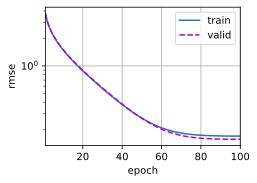

In [65]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [66]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162305


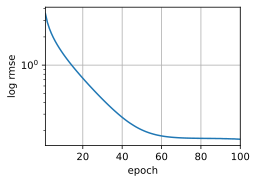

In [67]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)